In [5]:
import os,sys
print('original system paths are:','\n'.join(sys.path))
sys.path = ['',
            '/home/jovyan/work/envs/python36/lib/python36.zip', 
            '/home/jovyan/work/envs/python36/lib/python3.6', 
            '/home/jovyan/work/envs/python36/lib/python3.6/lib-dynload', 
            '/home/jovyan/work/envs/python36/lib/python3.6/site-packages']

os.chdir(r'/home/jovyan/work/垃圾注册')
print(f"current working dir: {os.getcwd()}")

original system paths are: C:\Users\King\OneDrive\life is hard\网易严选\风险水位模型
C:\Users\King\OneDrive\life is hard\网易严选
c:\users\king\appdata\local\programs\python\python39\python39.zip
c:\users\king\appdata\local\programs\python\python39\DLLs
c:\users\king\appdata\local\programs\python\python39\lib
c:\users\king\appdata\local\programs\python\python39

C:\Users\King\AppData\Roaming\Python\Python39\site-packages
c:\users\king\appdata\local\programs\python\python39\lib\site-packages
c:\users\king\appdata\local\programs\python\python39\lib\site-packages\win32
c:\users\king\appdata\local\programs\python\python39\lib\site-packages\win32\lib
c:\users\king\appdata\local\programs\python\python39\lib\site-packages\Pythonwin
c:\users\king\appdata\local\programs\python\python39\lib\site-packages\IPython\extensions
C:\Users\King\.ipython
C:\Program Files\JetBrains\PyCharm 2020.3.4\plugins\python\helpers\pydev
C:\Program Files\JetBrains\PyCharm 2020.3.4\plugins\python\helpers-pro\jupyter_debug


FileNotFoundError: [WinError 3] 系统找不到指定的路径。: '/home/jovyan/work/垃圾注册'

In [3]:
# gensim 没装成功
sys.path.append('/home/jovyan/.local/lib/python3.6/site-packages/')

In [1]:
import re
import numpy as np
import pandas as pd

In [8]:
def load_data(db, table,verbose=False,mode='utf-8'):
    from hdfs.ext.kerberos import KerberosClient
    import os,requests,hdfs

    session = requests.Session()
    session.verify = False
    if mode != 'utf-8':
        content = b''
    else:
        content = ''
    hdfs_data_dir = '/user/holmes/hive_db/'+ db + '.db/' + table
    try:
        hdfs_url = 'http://holmes-mm-master-1.hz.infra.mail:50070'
        client = KerberosClient(hdfs_url)
        hdfs_file_ls = [os.path.join(hdfs_data_dir, f) for f in client.list(hdfs_data_dir)]
    except hdfs.util.HdfsError as e:
        hdfs_url = 'http://holmes-mm-master-2.hz.infra.mail:50070'
        client = KerberosClient(hdfs_url)
        hdfs_file_ls = [os.path.join(hdfs_data_dir, f) for f in client.list(hdfs_data_dir)]        
    
    if verbose: print("hdfs_file_list: ", hdfs_file_ls)
    for f in hdfs_file_ls:
        with client.read(f) as reader:
            if mode != 'utf-8':
                content += reader.read()
            else:
                content += reader.read().decode("utf-8")
    return content

## step 1. read traindata and cvt to array

In [3]:
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation,concatenate,Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform

import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

In [10]:
cur_dir = '/home/jovyan/work/垃圾注册'
emb_fn = 'action_page_fasttext4signup.dict'
model_fn = 'lstm_onlyaction_originfasttext_20210607'
model_dir = os.path.join(cur_dir,'model',model_fn)
emb_dir = os.path.join(cur_dir,'model',emb_fn)
# model = load_model(model_dir)

In [11]:
tbl_cols = ["ds","risk_flag","user_id","action_sequence","time_sequence"]

target = "risk_flag"
# content = load_data(db='temp',table='rc_batch_register_train_sample_2')
content = load_data(db='temp',table='rc_batch_register_train_2')

# data = pd.DataFrame([i.split('\x01') for i in content.split('\n') if i.strip()!=''],columns=tbl_cols)
# data.head()
# data.risk_flag.value_counts()

ModuleNotFoundError: No module named 'hdfs'

In [8]:
def clean_features(content):
    """
    把数据表的数据转为 array
    """
    label,id_ls,ft_ls,actions_sequence,time_sequence = [],[],[],[],[]

    for line in content.split('\n'):
        ls = line.split('\x01')
        try:
            ds,risk_flag,user_id,*ft_cols,action,time = ls
        except ValueError:
            # print(ls)
            continue
        
        id_ls.append([ds,user_id])
        ft_ls.append(['0' if i=='' or re.search('[^\d.]',i) else i for i in ft_cols])
        
        label.append(risk_flag)
        # label.append([risk_flag])

        # 处理无埋点记录
        if action=='\\N':action='0'
        if time=='\\N':time='0'
        
        actions_sequence.append(action.split(','))
        time_sequence.append(list(map(int,time.split(','))))
    
    X = np.asarray(actions_sequence)
    T = np.asarray(time_sequence)
    Y = np.asarray(label, dtype=int)
    F = np.asarray(ft_ls, dtype=float)
    ID = np.asarray(id_ls)
    return X,T,Y,ID,F

In [9]:
X,T,Y,ID,F = clean_features(content)

/home/jovyan/work/envs/python36/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [10]:
X.shape,Y.shape,T.shape,ID.shape,F.shape

((77691,), (77691,), (77691,), (77691, 2), (77691, 0))

In [231]:
# from itertools import chain
# def shuffled_copies(*arrays,top_n=False):
#     p = np.random.permutation(len(arrays[0]))
#     if top_n:
#         for a in arrays:
#             print(f"dealing with: {a[0]}")
#             tmp = np.array(a.ravel())[p]
#             print(f"size of tmp: {tmp.shape}")
#             tmp = tmp[:top_n]
#             print(f"size of tmp: {tmp.shape}")
#             ans = tmp
#         # ans = list((np.array(np.array(a)[p]).reshape(-1,1)[:top_n]) for a in arrays)
#         print(f"size of ans:{len(ans)}")
#         return ans
#         # return (np.array(a)[p][:top_n] for a in arrays) #works4ab
#         # return ((np.array(np.array(a)[p])[:top_n]) for a in arrays)
#     return (np.array(a)[p] for a in arrays)

# mask = Y==1
# # neg_ls = X[~mask],T[~mask]],Y[~mask],ID[~mask],F[~mask]
# neg_ls = Y[~mask],ID[~mask]
# t_neg,y_neg = shuffled_copies(neg_ls, top_n=sum(mask))
# # x_neg,t_neg,y_neg,id_neg,f_neg = shuffled_copies(neg_ls, top_n=sum(mask))

## step2. train lstm model

In [37]:
from sklearn.model_selection import train_test_split
id_train,id_test,x_train,x_test,t_train,t_test,y_train,y_test,f_train,f_test = train_test_split(ID,X,T,Y,F, test_size=0.3, random_state=0)

In [38]:
id_train,id_valid,x_train,x_valid,t_train,t_valid,y_train,y_valid,f_train,f_valid = train_test_split(id_train,x_train,t_train,y_train,f_train, test_size=0.3, random_state=0)

In [31]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def RiskLevelPredict_with_loss(input_shape, action_to_vec_map, action_to_index, output_bias):
    # Define actions_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    actions_indices = Input(shape=input_shape, dtype=np.int32)

    # Create the embedding layer(≈1 line)
    embedding_layer = pretrained_embedding_layer(action_to_vec_map, action_to_index)
    # Propagate actions_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(actions_indices)
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    X = LSTM(128, return_sequences=True)(embeddings)
    
    # delta_time_indices = Input(shape=[input_shape[0],1])
    # X2 = LSTM(4, return_sequences=True)(delta_time_indices)
    # X = concatenate([X, X2])

    X = Dropout(0.5)(X)
    X = LSTM(128)(X)
    X = Dropout(0.5)(X)

    X = Dense(2, activation='softmax',bias_initializer=output_bias)(X)
    X = Activation('softmax')(X)

    # Create Model instance which converts actions_indices into X.
    # model = Model([actions_indices,delta_time_indices], X)
    model = Model(actions_indices, X)

    return model

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = RiskLevelPredict_with_loss((maxLen,), action_to_vec_map, action_to_index,output_bias)
    model.compile(
        loss='binary_crossentropy', 
        optimizer='adam', 
        metrics=metrics)
    return model

In [17]:
def pretrained_embedding_layer(action_to_vec_map, action_to_index):
    vocab_len = len(action_to_index) + 1  # adding 1 to fit Keras embedding (requirement)
    emb_dim = action_to_vec_map["login"].shape[0]  # define dimensionality
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of action vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the action vector representation of the "index"th action of the vocabulary
    try:
        for action, index in action_to_index.items():
            emb_matrix[index, :] = action_to_vec_map[action]
    except:
        pass
    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False.
    embedding_layer = Embedding(vocab_len, emb_dim)

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))

    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])

    return embedding_layer

def read_action_vecs(fn):
    with open(fn, 'r', encoding="utf8") as f:
        actions = set()
        action_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_action = line[0]
            actions.add(curr_action)
            action_to_vec_map[curr_action] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        actions_to_index = {}
        index_to_actions = {}
        for w in sorted(actions):
            actions_to_index[w] = i
            index_to_actions[i] = w
            i = i + 1
    return actions_to_index, index_to_actions, action_to_vec_map

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [19]:
# fasttext & time sequence training
from gensim.models import word2vec
fasttext_model = word2vec.Word2Vec.load("fasttext.model")

def actions_to_indices(X, action_to_index, max_len,ref="click"):
    m = X.shape[0]  # number of training examples
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_len))

    for i in range(m):  # loop over training examples
        # Convert the ith training actions in lower case and split is into actions. You should get a list of actions.
        actions = X[i]
        # Initialize j to 0
        j = 0
        # Loop over the action
        for a in actions:
            # print(a)
            # Set the (i,j)th entry of X_indices to the index of the correct action.
            # 如果不是常见动作，则最后一维补 1
            # a = a.lower().strip()
            a = a.strip()
            if a in action_to_index.keys():
                X_indices[i, j] = action_to_index[a]
            # elif hasattr(ref, '__class__'):
            # elif ref=='model':
            #     # 如果传递了一个语言模型,不行，需要同步更行 emb_fn
            #     X_indices[i, j] = fasttext_model.wv[a]
            elif a.split('_')[0]in action_to_index.keys():
                # print(f"transfoming new words:{a}")
                # 如果首字母在辞典里
                oov_set.add(a)
                X_indices[i, j] = action_to_index[a.split('_')[0]]
            else:
                # 使用默认 oov
                X_indices[i, j] = action_to_index[ref]
            # Increment j to j + 1
            j = j + 1
    print('\n'.join(list(oov_set)))
    return X_indices

def time_scalar(x):
    if x >=10800:
        return 1
    return x/10800

In [20]:
# t_scalar = [list(map(time_scalar,i)) for i in t]
maxLen = len(max(x_train, key=len))
Y_indices = convert_to_one_hot(y_train, C=2)
# 读取单个动作的 embedding，作数值索引
action_to_index, index_to_action, action_to_vec_map = read_action_vecs(emb_dir)
# # 把动作转为数值索引
X_indices = actions_to_indices(x_train, action_to_index, maxLen,ref="model")
# 反过来，最后的动作放在最后面
X_indices = np.array([i[::-1] for i in X_indices])
# T_indices = np.array([[-1]*(maxLen-len(i))+i[::-1] for i in t])
# T_indices = np.array([[-1]*(maxLen-len(i))+i[::-1] for i in t_scalar])

click_overAll
view_rcmdHotList
view_topicList
receive_push
view_tuishou
open_exchangedetail
view_distributionSmallKpiManager
open_community
click_aboutus
view_onsaleReplay
view_topiclist
view_coreDataUser
click_fillreplacegoodsinfo
view_quanzhanManagerSpu
view_itemGroupItemMemberManager
click_mainpagetab
open_switchlist
view_itemCenterRealtime
open_accountlinkmobregister
exit_app
click_shareruledesc
click_manu
login_coupon
view_coredata_item
exit_exchangedetail
login_aftersale
open_refunddetail
click_communityfeed
view_newmustbuy
click_logoutreason
scan_default
open_app
view_itemGroupTarget
view_launch
exit_accountlinkmobregister
receive_push_scanpage
click_rcmdHotList
exit_shotvideo
view_newUserRank
view_itemNewGroupZhuzhanManager
click_flow
click_searchKw
view_coredata_quanzhan
share_orderdetail
view_community
add_minicommoditydetails
click_ feedbackmoney
exit_community
click_item
view_itemNewGroupHot
exit_refunddetail
view_coredata_zhuzhan
login_orderlist
click_community
view_app
vi

In [39]:
Y_indices_val = convert_to_one_hot(y_valid, C=2)
X_indices_val = actions_to_indices(x_valid, action_to_index, maxLen,ref="click")
X_indices_val = np.array([i[::-1] for i in X_indices_val])

open_newitempre
click_overAll
exit_mycenter
view_rcmdHotList
view_view_/x/activity/fef1aa0fe1b2915c.html
view_topicList
receive_push
view_tuishou
exit_newitempre
open_exchangedetail
view_distributionSmallKpiManager
open_community
click_aboutus
view_onsaleReplay
open_collectiontopic
view_topiclist
view_coreDataUser
click_fillreplacegoodsinfo
view_quanzhanManagerSpu
view_itemGroupItemMemberManager
click_mainpagetab
open_switchlist
view_itemCenterRealtime
open_accountlinkmobregister
exit_app
click_shareruledesc
click_manu
login_coupon
view_coredata_item
exit_exchangedetail
open_refundlist
login_aftersale
open_refunddetail
click_communityfeed
exit_collectiontopic
view_newmustbuy
click_logoutreason
scan_default
open_app
view_itemGroupTarget
view_launch
exit_accountlinkmobregister
receive_push_scanpage
click_rcmdHotList
view_spuDevelopDetail
exit_shotvideo
view_newUserRank
view_itemNewGroupZhuzhanManager
click_flow
click_searchKw
receive_push_customerservice
view_coredata_quanzhan
view_cored

In [24]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [29]:
# With the default bias initialization the loss should be about math.log(2) = 0.69314
initial_bias = np.log(4796/(38068-4796))
initial_bias

-1.9369339652753428

In [32]:
import tempfile
model = make_model(output_bias=initial_bias)
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [40]:
X_indices_val.shape,Y_indices_val.shape

((16315, 200), (16315, 2))

In [41]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    X_indices,
    Y_indices,
    batch_size=BATCH_SIZE,
    epochs=100,
    callbacks=[early_stopping],
    validation_data=(X_indices_val, Y_indices_val), 
    # verbose=0
    )
model.save(model_dir)

Epoch 1/100
19/19 [==============================] - 139s 7s/step - loss: 0.4758 - tp: 84716.0000 - fp: 15996.0000 - tn: 84716.0000 - fn: 15996.0000 - accuracy: 0.8412 - precision: 0.8412 - recall: 0.8412 - auc: 0.8795 - prc: 0.8544 - val_loss: 0.4371 - val_tp: 14293.0000 - val_fp: 2022.0000 - val_tn: 14293.0000 - val_fn: 2022.0000 - val_accuracy: 0.8761 - val_precision: 0.8761 - val_recall: 0.8761 - val_auc: 0.8772 - val_prc: 0.8488
Epoch 2/100
19/19 [==============================] - 138s 7s/step - loss: 0.4388 - tp: 33287.0000 - fp: 4781.0000 - tn: 33287.0000 - fn: 4781.0000 - accuracy: 0.8744 - precision: 0.8744 - recall: 0.8744 - auc: 0.8757 - prc: 0.8470 - val_loss: 0.4362 - val_tp: 14301.0000 - val_fp: 2014.0000 - val_tn: 14301.0000 - val_fn: 2014.0000 - val_accuracy: 0.8766 - val_precision: 0.8766 - val_recall: 0.8766 - val_auc: 0.8798 - val_prc: 0.8518
Epoch 3/100
19/19 [==============================] - 136s 7s/step - loss: 0.4348 - tp: 33386.0000 - fp: 4682.0000 - tn: 33386.

In [54]:
# t_scalar = [list(map(time_scalar,i)) for i in t]
maxLen = len(max(x_train, key=len))
Y_indices = convert_to_one_hot(y_train, C=2)
# 读取单个动作的 embedding，作数值索引
action_to_index, index_to_action, action_to_vec_map = read_action_vecs(emb_dir)
# # 把动作转为数值索引
X_indices = actions_to_indices(x_train, action_to_index, maxLen,ref="model")
# 反过来，最后的动作放在最后面
X_indices = np.array([i[::-1] for i in X_indices])
# T_indices = np.array([[-1]*(maxLen-len(i))+i[::-1] for i in t])
# T_indices = np.array([[-1]*(maxLen-len(i))+i[::-1] for i in t_scalar])

open_switchlist
click_shareruledesc
view_coreDataUser
click_rcmdHotList
exit_exchangedetail
view_launch
receive_push_scanpage
click_exchangedetail
view_coreDataFlow
view_itemCenterRealtime
login_coupon
view_itemNewGroupQuanzhan
click_manu
view_coredata_zhuzhan
receive_push_login
view_coredata_hot
view_app
click_aboutus
view_newmustbuy
login_orderlist
exit_accountlinkmobregister
view_timelimit
open_exchangedetail
view_view_/x/activity/fef1aa0fe1b2915c.html
view_expertresult
view_itemNewGroupHot
click_community
login_aftersale
share_settings
view_quanzhanLvyueProfit
view_coredata_quanzhan
view_community
click_tuishou
view_topiclist
exit_refundlist
view_itemGroupItemMemberManager
receive_push
share_orderdetail
scan_default
exit_refunddetail
open_collectiontopic
view_distributionSmallKpiManager
open_refunddetail
click_flow
view_spuDevelopDetail
add_pointsdetail
click_quanzhan
exit_app
view_coredata_item
click_communityfeed
exit_mycenter
view_quanzhanManagerSpu
click_item
view_newUserRank
o

In [55]:
def RiskLevelPredict(input_shape, action_to_vec_map, action_to_index):
    # Define actions_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    actions_indices = Input(shape=input_shape, dtype=np.int32)

    # Create the embedding layer(≈1 line)
    embedding_layer = pretrained_embedding_layer(action_to_vec_map, action_to_index)
    # Propagate actions_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(actions_indices)
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    X = LSTM(128, return_sequences=True)(embeddings)
    
    # delta_time_indices = Input(shape=[input_shape[0],1])
    # X2 = LSTM(4, return_sequences=True)(delta_time_indices)
    # X = concatenate([X, X2])

    X = Dropout(0.5)(X)
    X = LSTM(128)(X)
    X = Dropout(0.5)(X)

    X = Dense(2, activation='softmax')(X)
    X = Activation('softmax')(X)

    # Create Model instance which converts actions_indices into X.
    # model = Model([actions_indices,delta_time_indices], X)
    model = Model(actions_indices, X)

    return model

In [56]:
model = RiskLevelPredict((maxLen,), action_to_vec_map, action_to_index)
model.summary()
model.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=[tf.keras.metrics.FalsePositives()])
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['Accuracy'])
model.fit(X_indices, Y_indices, epochs=50, batch_size=64, shuffle=True)
model.save(model_dir)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 200, 20)           12360     
_________________________________________________________________
lstm_6 (LSTM)                (None, 200, 128)          76288     
_________________________________________________________________
dropout_6 (Dropout)          (None, 200, 128)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258 

In [57]:
# 抽样训练集和全量训练集的准确率
data = load_data(db='temp',table='rc_batch_register_train_2')
X_all,T_all,Y_all,ID_all,F_all = clean_features(data)

/home/jovyan/work/envs/python36/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [58]:
maxLen = len(max(X_all, key=len))
action_to_index, index_to_action, action_to_vec_map = read_action_vecs(emb_dir)
model = load_model(model_dir)
# # 把动作转为数值索引
X_ALL_indices = actions_to_indices(X_all, action_to_index, maxLen,ref="click")
# 反过来，最后的动作放在最后面
X_ALL_indices = np.array([i[::-1] for i in X_ALL_indices])

pred_ALL = model.predict(X_ALL_indices)[:,1]

open_switchlist
click_shareruledesc
view_coreDataUser
click_rcmdHotList
exit_exchangedetail
view_launch
receive_push_scanpage
click_exchangedetail
view_coreDataFlow
view_itemCenterRealtime
login_coupon
view_itemNewGroupQuanzhan
click_manu
view_coredata_zhuzhan
receive_push_login
view_coredata_hot
view_app
click_aboutus
view_newmustbuy
login_orderlist
exit_accountlinkmobregister
view_timelimit
open_exchangedetail
view_view_/x/activity/fef1aa0fe1b2915c.html
view_expertresult
view_itemNewGroupHot
click_community
login_aftersale
share_settings
view_quanzhanLvyueProfit
view_coredata_quanzhan
view_community
click_tuishou
view_topiclist
exit_refundlist
view_itemGroupItemMemberManager
receive_push
share_orderdetail
scan_default
exit_refunddetail
open_collectiontopic
view_distributionSmallKpiManager
open_refunddetail
click_flow
view_spuDevelopDetail
add_pointsdetail
click_quanzhan
exit_app
view_coredata_item
click_communityfeed
exit_mycenter
view_quanzhanManagerSpu
click_item
view_newUserRank
o

In [59]:
X_indices= actions_to_indices(X, action_to_index, maxLen,ref="click")
pred = model.predict(X_indices)[:,1]

open_switchlist
click_shareruledesc
view_coreDataUser
click_rcmdHotList
exit_exchangedetail
view_launch
receive_push_scanpage
click_exchangedetail
view_coreDataFlow
view_itemCenterRealtime
login_coupon
view_itemNewGroupQuanzhan
click_manu
view_coredata_zhuzhan
receive_push_login
view_coredata_hot
view_app
click_aboutus
view_newmustbuy
login_orderlist
exit_accountlinkmobregister
view_timelimit
open_exchangedetail
view_view_/x/activity/fef1aa0fe1b2915c.html
view_expertresult
view_itemNewGroupHot
click_community
login_aftersale
share_settings
view_quanzhanLvyueProfit
view_coredata_quanzhan
view_community
click_tuishou
view_topiclist
exit_refundlist
view_itemGroupItemMemberManager
receive_push
share_orderdetail
scan_default
exit_refunddetail
open_collectiontopic
view_distributionSmallKpiManager
open_refunddetail
click_flow
view_spuDevelopDetail
add_pointsdetail
click_quanzhan
exit_app
view_coredata_item
click_communityfeed
exit_mycenter
view_quanzhanManagerSpu
click_item
view_newUserRank
o

In [47]:
import sys
sys.path.append('..')

from eval_model import *

../eval_model.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ksds['cumsum_good2'] = ksds2['cumsum_good2']


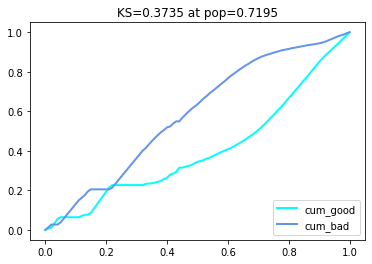

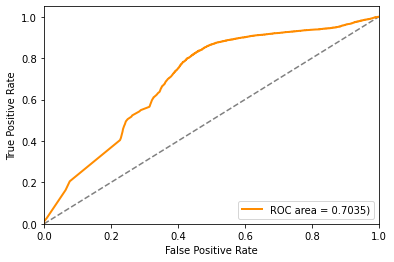

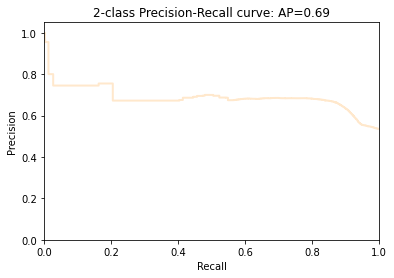

Model Report under New Threshold...
Accuracy: 0.6963
Precision:0.6728
Recall:   0.8413
f1-score: 0.7477
ROC_AUC:  0.6853


In [60]:
_ = plotKS(Y,pred,n=100,asc=0)
plotROC(Y,pred)
plotPR(Y,pred)
modelReport(Y,pred,0.7)

../eval_model.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ksds['cumsum_good2'] = ksds2['cumsum_good2']


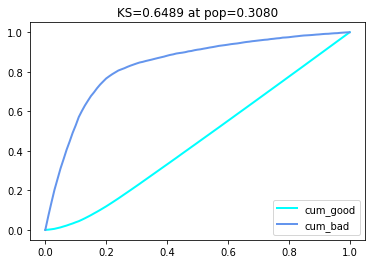

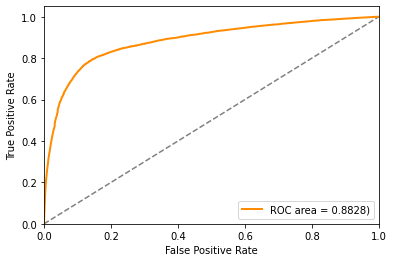

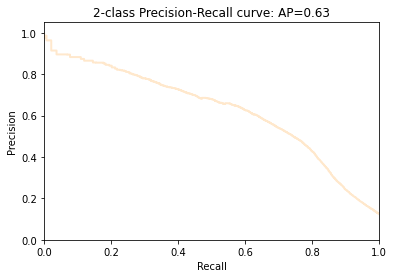

Model Report under New Threshold...
Accuracy: 0.8807
Precision:0.5159
Recall:   0.7274
f1-score: 0.6036
ROC_AUC:  0.8150


In [61]:
## p@r
# plotLift(Y_all,pred_ALL,n_cut=10)
_ = plotKS(Y_all,pred_ALL,n=100,asc=0)
plotROC(Y_all,pred_ALL)
plotPR(Y_all,pred_ALL)
modelReport(Y_all,pred_ALL,0.7)

../eval_model.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ksds['cumsum_good2'] = ksds2['cumsum_good2']


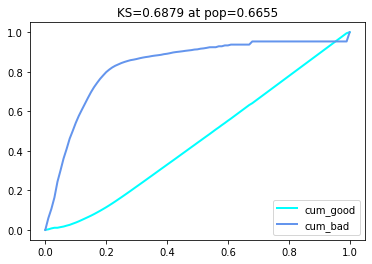

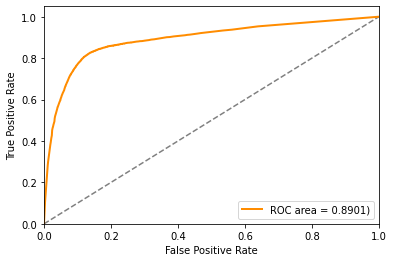

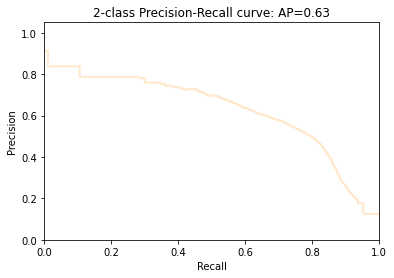

Model Report under New Threshold...
Accuracy: 0.8643
Precision:0.4750
Recall:   0.8159
f1-score: 0.6004
ROC_AUC:  0.8436


In [26]:
# plotLift(Y_all,pred_ALL,n_cut=10)
_ = plotKS(Y_all,pred_ALL,n=100,asc=0)
plotROC(Y_all,pred_ALL)
plotPR(Y_all,pred_ALL)
modelReport(Y_all,pred_ALL,0.7)

In [62]:
pd.Series(pred_ALL).describe()

count    77691.000000
mean         0.360807
std          0.179072
min          0.268942
25%          0.268945
50%          0.268964
75%          0.273869
max          0.731058
dtype: float64

In [64]:
modelReport(Y_all,pred_ALL,0.73105)

Model Report under New Threshold...
Accuracy: 0.9064
Precision:0.7181
Recall:   0.4132
f1-score: 0.5246
ROC_AUC:  0.6950


In [18]:
## 查看正确/误分样本的轨迹
acc = Y_all==np.where(pred_ALL>0.7,1,0)
pos = Y_all==1
dt = ID_all[:,0]=='2021-04-16'

In [19]:
tp,fp,tn,fn = ID_all[acc & pos],ID_all[~acc & ~pos],ID_all[acc & ~pos],ID_all[~acc&pos]
# tp,fp,tn,fn = ID_all[dt&acc&pos],ID_all[dt&~acc&~pos],ID_all[dt&acc&~pos],ID_all[dt&~acc&pos]

In [20]:
ID_all.shape,acc.shape,pos.shape

((77691, 2), (77691,), (77691,))

In [21]:
Y_all.shape,pred_ALL.shape

((77691,), (77691,))

In [22]:
tp.shape,fp.shape,tn.shape,fn.shape

((4770, 2), (7080, 2), (64506, 2), (1335, 2))

In [36]:
'26229318087' in tp,'26229318087' in fp,'26229318087' in fn

(True, False, False)

In [98]:
# tp[:5],fp[:5],tn[:5],fn[:5]
tp[:5,1],fp[:5,1],tn[:5,1],fn[:5,1]


(array(['26229483382', '26229483392', '26229484337', '26229484570',
        '26229484572'], dtype='<U11'),
 array(['26229483415', '26229483515', '26229483527', '26229483549',
        '26229483688'], dtype='<U11'),
 array(['26229156578', '26229357500', '26229483313', '26229483321',
        '26229483322'], dtype='<U11'),
 array(['26229483553', '26229484600', '26229485324', '26229486626',
        '26229489429'], dtype='<U11'))

In [101]:
print(fp[:,1])

['26229483415' '26229483515' '26229483527' '26229483549' '26229483688'
 '26229483795' '26229483845' '26229484534' '26229484626' '26229484842'
 '26229485306' '26229485384' '26229486453' '26229487344' '26229487484'
 '26229487517' '26229487756' '26229488454' '26229488499' '26229488788'
 '26229489564' '26229489629' '26229490461' '26229490540' '26229490561'
 '26229490593' '26229490653' '26229490802' '26229490837' '26229491516'
 '26229491808' '26229492473' '26229492520' '26229492615' '26229492692'
 '26229492698' '26229492823' '26229493438' '26229493456' '26229493659'
 '26229494461' '26229494531' '26229494533' '26229494777' '26229495483'
 '26229495721' '26229495750' '26229495755' '26229496367' '26229496446'
 '26229496573' '26229496833' '26229496853' '26229497353' '26229497578'
 '26229498267' '26229499520' '26229499533' '26229499588' '26229499591'
 '26229499805' '26229500299' '26229500648' '26229500788' '26229501322'
 '26229501541' '26229501623' '26229502517' '26229502814' '26229503490'
 '2622